# Using Feature Engineering Techniques to Improve Multivariate Model Forecasting of the South African Unemployment Rate

In [2]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from tsfresh.utilities.dataframe_functions import roll_time_series

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

warnings.filterwarnings('ignore')

In [3]:
# reading in the csv
feature_set_sarb = pd.read_csv('sarb_features_data.csv').drop(['unemployment rate'], axis=1).set_index('Date')
target = pd.read_csv('sarb_target_data.csv').set_index('Date')
feature_set_sarb.index = pd.to_datetime(feature_set_sarb.index)
target.index = pd.to_datetime(target.index)

In [5]:
# shape of the dataset before experimentation
feature_set_sarb.shape

(1432, 147)

In [6]:
# in this research we only going to work with monthly data
N = feature_set_sarb.shape[0]
# remove annual data
feature_set_sarb=feature_set_sarb[feature_set_sarb.columns[feature_set_sarb.isnull().mean() < (N-(98))/N]]
# remove quaterly data 
feature_set_sarb=feature_set_sarb[feature_set_sarb.columns[feature_set_sarb.isnull().mean() < (N-(393))/N]]

# base dataset

In [7]:
benchmark_x = feature_set_sarb.copy()
benchmark_y = target.copy()

valid_start = benchmark_y.first_valid_index()
benchmark_y = benchmark_y[valid_start : ]
benchmark_x = benchmark_x[valid_start : ]

In [8]:
benchmark_y = benchmark_y.fillna(0)
benchmark_x = benchmark_x.fillna(0)

# Imputation 


In [9]:
# Since we are interested in imputing missing values, it would be useful to see the distribution in missing values across columns.

# This displays the number of non-null values in each column:

print(feature_set_sarb.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1432 entries, 1922-01-01 to 2020-01-01
Data columns (total 47 columns):
 #   Column                                                                                                                                                                                                                                                                                                      Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                                                                                      --------------  -----  
 0   Domestic output: All groups                                                                                                                                                                                         

In [10]:
#calculating  the number of missing values in each column 
feature_set_sarb.isnull().sum()

Domestic output: All groups                                                                                                                                                                                                                                                                                    832
Foreign exchange rate : SA rand per USA dollar                                                                                                                                                                                                                                                                 711
Total outstanding domestic non-marketable bills                                                                                                                                                                                                                                                                712
Financing by non-marketable bonds                                              

### foward fill imputation

In [11]:
#Data imputation strategy is foward fill
x_values_ffill = feature_set_sarb.fillna(method='ffill')
y_values_ffill = target.fillna(method='ffill')

In [12]:
# Remove all data points before unemployment rate data is available. Unemployment rate is my target variable.
valid_start = y_values_ffill.first_valid_index()
y_values_ffill = y_values_ffill[valid_start : ]
x_values_ffill = x_values_ffill[valid_start : ]

(array([156., 103.,  67.,  19.,  23.,  32.,  45.,  96., 205.,  48.]),
 array([ 6.10705 ,  8.406345, 10.70564 , 13.004935, 15.30423 , 17.603525,
        19.90282 , 22.202115, 24.50141 , 26.800705, 29.1     ]),
 <BarContainer object of 10 artists>)

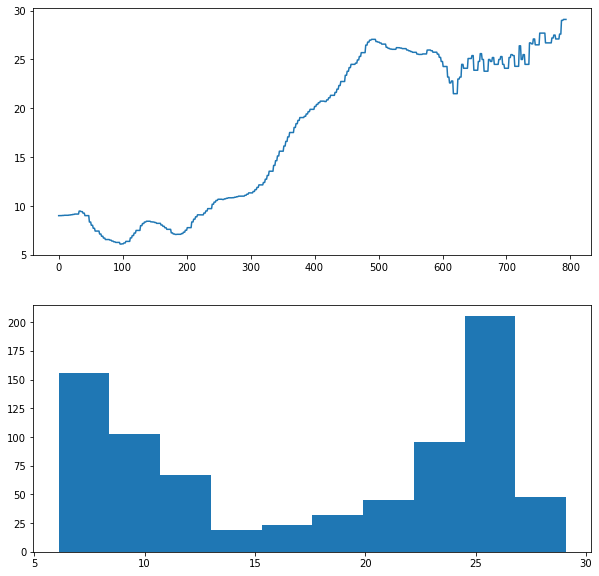

In [13]:
x_values_ffill = x_values_ffill.fillna(0) 
fig,ax = plt.subplots(2,figsize=(10,10))
ax[0].plot(y_values_ffill.values)
ax[1].hist(y_values_ffill.values)

## Univariate feature imputation

In [14]:
df_x = feature_set_sarb.copy()
df_y = target.copy()

df_x = df_y[valid_start : ]

# using three different imputation strategies
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')


X_uni_mean = imp_mean.fit_transform(df_x,y_values_ffill)
X_uni_median = imp_median.fit_transform(df_x,y_values_ffill)
X_uni_most_frequent = imp_most_frequent.fit_transform(df_x,y_values_ffill)

## Multivariate feature imputation

In [15]:
imp_iter = IterativeImputer(random_state=0)
x_iter = imp_iter.fit_transform(df_x,y_values_ffill)

## KNN imputer

In [16]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
x_knn = imputer.fit_transform(df_x,y_values_ffill)

# testing imputation methods

In [17]:
sc_x = StandardScaler()
sc_y = StandardScaler()
tscv = TimeSeriesSplit(test_size=24)
svr = SVR(C= 10, gamma='auto', kernel='rbf')

In [18]:
# forward fill base
benchmark = []

X = benchmark_x.values
y = benchmark_y.values
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = sc_x.fit_transform(X_train)
    y_train = sc_y.fit_transform(y_train)
    
    svr.fit(X_train,y_train)
    
    X_test = sc_x.fit_transform(X_test)
    y_test = sc_y.fit_transform(y_test)
    
    score = svr.score(X_test,y_test)
    
    benchmark.append(score)
    
    print(score)

0.20998520656788167
0.20281468138253855
0.07873170263973084
0.4178201025401328
0.27475896731051075


In [19]:
# forward fill testing
ffill = []

X = x_values_ffill.values
y = y_values_ffill.values
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = sc_x.fit_transform(X_train)
    y_train = sc_y.fit_transform(y_train)
    
    svr.fit(X_train,y_train)
    
    X_test = sc_x.fit_transform(X_test)
    y_test = sc_y.fit_transform(y_test)
    
    score = svr.score(X_test,y_test)
    
    ffill.append(score)
    
    print(score)

-0.5327294032250416
-0.24730980198869057
0.09134026114216687
-0.6125158651712648
0.49629680302684187


In [20]:
# univariate imputation testing: mean
mean = []

X = X_uni_mean
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = sc_x.fit_transform(X_train)
    y_train = sc_y.fit_transform(y_train)
    
    svr.fit(X_train,y_train)
    
    X_test = sc_x.fit_transform(X_test)
    y_test = sc_y.fit_transform(y_test)
    
    score = svr.score(X_test,y_test)
    
    mean.append(score)
    
    print(score)

-0.21416379299481592
0.15596905996039845
0.004216156532826587
0.03775340006927719
-0.05697838643302


In [21]:
# univariate imputation testing: median
median = []

X = X_uni_median
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = sc_x.fit_transform(X_train)
    y_train = sc_y.fit_transform(y_train)
    
    svr.fit(X_train,y_train)
    
    X_test = sc_x.fit_transform(X_test)
    y_test = sc_y.fit_transform(y_test)
    
    score = svr.score(X_test,y_test)
    
    median.append(score)
    
    print(score)

-0.41182532616295897
-0.003219636252888902
-0.16435726585605992
-0.06648153921556688
-0.10126319160140929


In [22]:
# univariate imputation testing: most frequent

most_frequent = []

X = X_uni_most_frequent
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = sc_x.fit_transform(X_train)
    y_train = sc_y.fit_transform(y_train)
    
    svr.fit(X_train,y_train)
    
    X_test = sc_x.fit_transform(X_test)
    y_test = sc_y.fit_transform(y_test)
    
    score = svr.score(X_test,y_test)
    
    most_frequent.append(score)
    
    print(score)

-0.5241482587769017
-0.582374363369643
-0.8029925145898933
-0.9853086743604864
-1.3076164458196726


In [23]:
# univariate imputation testing: Multivariate imputer
multi = []

X = x_iter
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = sc_x.fit_transform(X_train)
    y_train = sc_y.fit_transform(y_train)
    
    svr.fit(X_train,y_train)
    
    X_test = sc_x.fit_transform(X_test)
    y_test = sc_y.fit_transform(y_test)
    
    score = svr.score(X_test,y_test)
    
    multi.append(score)
    
    print(score)

-0.21416379299481592
0.15596905996039845
0.004216156532826587
0.03775340006927719
-0.05697838643302


In [24]:
# univariate imputation testing: KNN
KNN = []
X = x_knn

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = sc_x.fit_transform(X_train)
    y_train = sc_y.fit_transform(y_train)
    
    svr.fit(X_train,y_train)
    
    X_test = sc_x.fit_transform(X_test)
    y_test = sc_y.fit_transform(y_test)
    
    score = svr.score(X_test,y_test)
    
    KNN.append(score)
    
    print(score)

-0.21416379299481592
0.15596905996039845
0.004216156532826587
0.03775340006927719
-0.05697838643302


In [25]:
imdf = pd.DataFrame([benchmark,mean,ffill,median,KNN,multi,most_frequent],['benchmark','mean','ffill','median','KNN','multi','most_frequent'])
imdf['class'] = imdf.index
imdf.reset_index(drop=True)
c=imdf.melt(id_vars='class')
imdf.T

,benchmark,mean,ffill,median,KNN,multi,most_frequent
0,0.209985,-0.214164,-0.532729,-0.411825,-0.214164,-0.214164,-0.524148
1,0.202815,0.155969,-0.24731,-0.00322,0.155969,0.155969,-0.582374
2,0.078732,0.004216,0.09134,-0.164357,0.004216,0.004216,-0.802993
3,0.41782,0.037753,-0.612516,-0.066482,0.037753,0.037753,-0.985309
4,0.274759,-0.056978,0.496297,-0.101263,-0.056978,-0.056978,-1.307616
class,benchmark,mean,ffill,median,KNN,multi,most_frequent


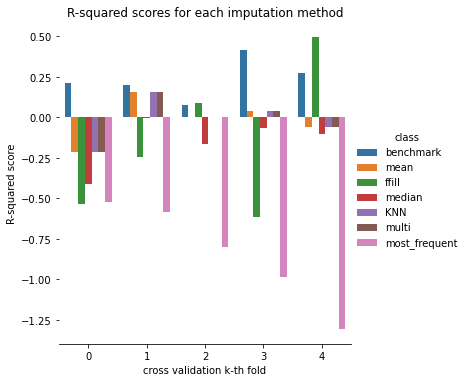

In [26]:
g = sns.catplot(
    data=c, kind="bar",
    x='variable', y='value', hue = 'class',
)
plt.title("R-squared scores for each imputation method")
g.despine(left=True)
g.set_axis_labels("cross validation k-th fold", "R-squared score")
plt.savefig('imputation scores')

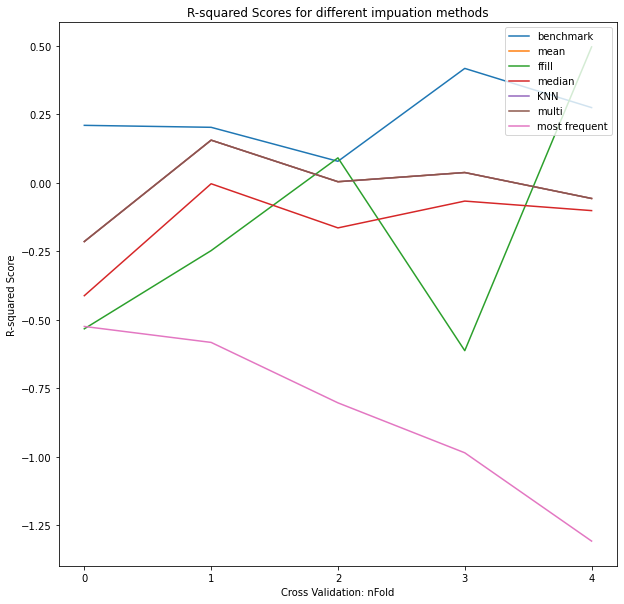

In [27]:
plt.figure(figsize=(10,10))
plt.title('R-squared Scores for different impuation methods')
plt.xlabel('Cross Validation: nFold')
plt.ylabel('R-squared Score')
plt.xticks([0,1,2,3,4,5])
plt.plot([0,1,2,3,4],benchmark,label='benchmark')
plt.plot(mean, label='mean')
plt.plot(ffill, label='ffill')
plt.plot(median, label='median')
plt.plot(KNN, label='KNN')
plt.plot(multi, label='multi')
plt.plot(most_frequent, label='most frequent')
plt.legend(loc='upper right')
plt.savefig('imputation.png')


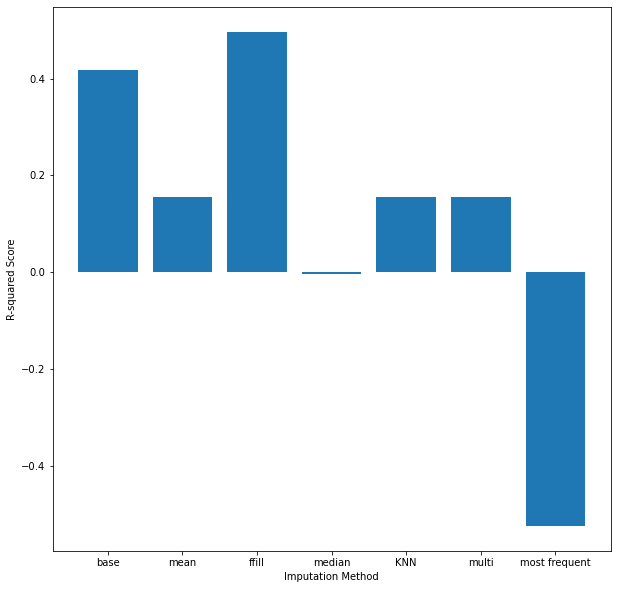

In [28]:
plt.figure(figsize=(10,10))
plt.xlabel('Imputation Method')
plt.ylabel('R-squared Score')
plt.bar(['base','mean','ffill', 'median','KNN','multi','most frequent'], 
        [max(benchmark),max(mean),max(ffill),max(median),max(KNN),max(multi),max(most_frequent)])
plt.savefig('imputation_bar.png')

# Creating Features

In [29]:
df_x = x_values_ffill.copy()
df_y = y_values_ffill.copy()
extracted_df = pd.DataFrame()

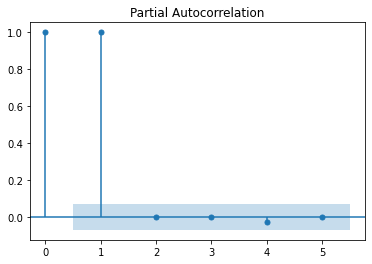

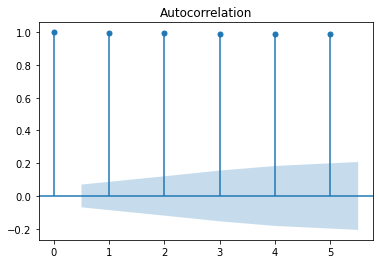

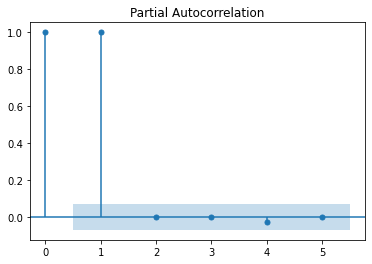

In [30]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df_y['unemployment rate'], lags=5)
plot_pacf(df_y['unemployment rate'], lags=5)

## Lag values

In [31]:
# adding lag values
extracted_df['lag_1'] = df_y['unemployment rate'].shift(1)
extracted_df['lag_2'] = df_y['unemployment rate'].shift(2)

In [32]:
extracted_df
lag_ft = ['lag_1','lag_2']

## statistical features

In [33]:
# extracting features 
cols = df_x.columns.values
stat_ft = []

for c in cols:
    
    new_name = c+'_mean'
    stat_ft.append(new_name)
    
    extracted_df[new_name] = df_x[c].rolling(window=7).mean()
    
    new_name = c+'_std'
    stat_ft.append(new_name)
    
    extracted_df[new_name] = df_x[c].rolling(window=7).std()

    new_name = c+'_aad'
    stat_ft.append(new_name)
    
    extracted_df[new_name] = df_x[c].rolling(window=7).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    new_name = c+'_min'
    stat_ft.append(new_name)
    
    extracted_df[new_name] = df_x[c].rolling(window=7).min()

    new_name = c+'_max'
    stat_ft.append(new_name)
    
    extracted_df[new_name] = df_x[c].rolling(window=7).max()

    new_name = c+'_median'
    stat_ft.append(new_name)
    
    extracted_df[new_name] = df_x[c].rolling(window=7).median()

    new_name = c+'_mad'
    stat_ft.append(new_name)
    
    extracted_df[new_name] = df_x[c].rolling(window=7).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    new_name = c+'_iqr'
    stat_ft.append(new_name)
    
    extracted_df[new_name] = df_x[c].rolling(window=7).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    
    new_name = c+'_nc'
    stat_ft.append(new_name)
    
    extracted_df[new_name] = df_x[c].rolling(window=7).apply(lambda x: np.sum(x < 0))

    new_name = c+'_pc'
    stat_ft.append(new_name)
    
    extracted_df[new_name] = df_x[c].rolling(window=7).apply(lambda x: np.sum(x > 0))
        
    new_name = c+'_skewness'
    stat_ft.append(new_name)
    
    extracted_df[new_name] = df_x[c].rolling(window=7).apply(lambda x: stats.skew(x))
        
    new_name = c+'_kurtosis'
    stat_ft.append(new_name)
    
    extracted_df[new_name] = df_x[c].rolling(window=7).apply(lambda x: stats.kurtosis(x))

    new_name = c+'_energy'
    stat_ft.append(new_name)
    
    extracted_df[new_name] = df_x[c].rolling(window=7).apply(lambda x: np.sum(x**2)/100)

        
extracted_df.head()#

,lag_1,lag_2,Domestic output: All groups _mean,Domestic output: All groups _std,Domestic output: All groups _aad,Domestic output: All groups _min,Domestic output: All groups _max,Domestic output: All groups _median,Domestic output: All groups _mad,Domestic output: All groups _iqr,...,CPI Headline _min,CPI Headline _max,CPI Headline _median,CPI Headline _mad,CPI Headline _iqr,CPI Headline _nc,CPI Headline _pc,CPI Headline _skewness,CPI Headline _kurtosis,CPI Headline _energy
Date,,,,,,,,,,,,,,,,,,,,,
1970-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-04-01,9.01386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-05-01,9.01386,9.01386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-06-01,9.01386,9.01386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-07-01,9.02202,9.01386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# converting the signals from time domain to frequency domain using FFT
df_x_fft = pd.DataFrame(np.fft.fft(df_x), columns = cols)
df_x_fft.head(3)

,Domestic output: All groups,Foreign exchange rate : SA rand per USA dollar,Total outstanding domestic non-marketable bills,Financing by non-marketable bonds,Total gross loan debt (nsa),Financial guarantees by government,Total cash-flow revenue,Total outstanding domestic non-marketable bonds,"Cash received from the issuance of other debt instruments less cash payments made to redeem other debt instruments, including non-marketable bills and bonds, and debt of the former TBVC-countries, self-governing territories and the Republic of Namibia that were assumed by the national government.",Total outstanding domestic non-marketable debt,...,National government revenue adjusted for differences in timing between the recording of transactions and bank clearances.,Claims on the domestic private sector,Total foreign non-marketable debt,Total outstanding foreign marketable bonds by unexpired maturity: Exceeding 3 years,Broad monetary credit to the government sector,"National government expenditure adjusted for differences between the recording of transactions and bank clearances, and late departmental requests/surrenders of funds.",The nominal effective exchange rate is a weighted exchange rate of the rand measured against a basket of the currencies of South Africa's twenty most important trading partners. The calculation is based on trade in and consumption of manufactured goo,"The leading business cycle indicator is a composite index comprising of time series, which tend to shift direction in advance of the business cycle. Frequency = monthly. Currency = index (2015 = 100). The time series is seasonally adjusted.",Physical volume of manufacturing production: Total,CPI Headline
0,33599.66+0.00j,3467.418357+12834.669403j,-9497.904678+3640.117267j,-4667.253540-18513.471583j,-2499.333154-4106.437803j,5928.114285-487.912160j,-9011.416935+5058.416987j,-10527.319990+7054.104849j,-7220.204835-9303.632875j,5643.767454+4229.745075j,...,11923.135400-8297.801469j,5643.767454-4229.745075j,-7220.204835+9303.632875j,-10527.319990-7054.104849j,-9011.416935-5058.416987j,5928.114285+487.912160j,-2499.333154+4106.437803j,-4667.253540+18513.471583j,-9497.904678-3640.117267j,3467.418357-12834.669403j
1,33788.16+0.00j,3265.472228+13062.619620j,-9964.765155+3139.560811j,-4493.219878-18732.484554j,-1813.091398-3874.699542j,5892.327215-869.335885j,-9369.866979+5070.627662j,-10070.302182+7793.538902j,-7180.788308-9185.455826j,5175.653428+4111.566288j,...,11904.116554-8431.574430j,5175.653428-4111.566288j,-7180.788308+9185.455826j,-10070.302182-7793.538902j,-9369.866979-5070.627662j,5892.327215+869.335885j,-1813.091398+3874.699542j,-4493.219878+18732.484554j,-9964.765155-3139.560811j,3265.472228-13062.619620j
2,33817.96+0.00j,3157.350997+13029.559125j,-10002.267906+3259.201263j,-4494.985491-18814.858544j,-1814.693583-3908.027975j,5937.883749-758.306450j,-9341.891571+5132.391355j,-9996.976934+7736.264689j,-7220.491816-9141.483316j,5247.320083+4178.953929j,...,11736.590087-8332.092612j,5247.320083-4178.953929j,-7220.491816+9141.483316j,-9996.976934-7736.264689j,-9341.891571-5132.391355j,5937.883749+758.306450j,-1814.693583+3908.027975j,-4494.985491+18814.858544j,-10002.267906-3259.201263j,3157.350997-13029.559125j


## frequency Domain Features

In [35]:
# extracting frequency domain features
fq_ft = []

cols = df_x.columns.values
for c in cols:
    new_name = c+'_mean_fft'
    fq_ft.append(new_name)
    
    extracted_df[new_name] = df_x_fft[c].rolling(window=7).mean()
    
    new_name = c+'_std_fft'
    fq_ft.append(new_name)
    
    extracted_df[new_name] = df_x_fft[c].rolling(window=7).std()


    new_name = c+'_aad_fft'
    fq_ft.append(new_name)
    
    extracted_df[new_name] = df_x_fft[c].rolling(window=7).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))


    new_name = c+'_min_fft'
    fq_ft.append(new_name)
    
    extracted_df[new_name] = df_x_fft[c].rolling(window=7).min()

    new_name = c+'_max_fft'
    fq_ft.append(new_name)
    
    extracted_df[new_name] = df_x_fft[c].rolling(window=7).max()


    new_name = c+'_median_fft'
    fq_ft.append(new_name)
    
    extracted_df[new_name] = df_x_fft[c].rolling(window=7).median()

    new_name = c+'_mad_fft'
    fq_ft.append(new_name)
    
    extracted_df[new_name] = df_x_fft[c].rolling(window=7).apply(lambda x: np.median(np.absolute(x - np.median(x))))


    new_name = c+'_iqr_fft'
    fq_ft.append(new_name)
    
    extracted_df[new_name] = df_x_fft[c].rolling(window=7).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    new_name = c+'_nc_fft'
    fq_ft.append(new_name)
    
    extracted_df[new_name] = df_x_fft[c].rolling(window=7).apply(lambda x: np.sum(x < 0))

    new_name = c+'_pc_fft'
    fq_ft.append(new_name)
    
    extracted_df[new_name] = df_x_fft[c].rolling(window=7).apply(lambda x: np.sum(x > 0))
        

    new_name = c+'_skewness_fft'
    fq_ft.append(new_name)
    
    extracted_df[new_name] = df_x_fft[c].rolling(window=7).apply(lambda x: stats.skew(x))
        
    new_name = c+'_kurtosis_fft'
    fq_ft.append(new_name)
    
    extracted_df[new_name] = df_x_fft[c].rolling(window=7).apply(lambda x: stats.kurtosis(x))

    new_name = c+'_energy_fft'
    fq_ft.append(new_name)
    
    extracted_df[new_name] = df_x_fft[c].rolling(window=7).apply(lambda x: np.sum(x**2)/100)

        
extracted_df.head()#

,lag_1,lag_2,Domestic output: All groups _mean,Domestic output: All groups _std,Domestic output: All groups _aad,Domestic output: All groups _min,Domestic output: All groups _max,Domestic output: All groups _median,Domestic output: All groups _mad,Domestic output: All groups _iqr,...,CPI Headline _min_fft,CPI Headline _max_fft,CPI Headline _median_fft,CPI Headline _mad_fft,CPI Headline _iqr_fft,CPI Headline _nc_fft,CPI Headline _pc_fft,CPI Headline _skewness_fft,CPI Headline _kurtosis_fft,CPI Headline _energy_fft
Date,,,,,,,,,,,,,,,,,,,,,
1970-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-04-01,9.01386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-05-01,9.01386,9.01386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-06-01,9.01386,9.01386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-07-01,9.02202,9.01386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# filling in all the missing values with 0
extracted_df.fillna(0,inplace=True)

In [37]:
# creating a temporary dataframe to find the best unemployment rate predictor

temp_df = df_x.copy()
temp_df['unemployment rate'] = df_y['unemployment rate']
temp_df.head()

,Domestic output: All groups,Foreign exchange rate : SA rand per USA dollar,Total outstanding domestic non-marketable bills,Financing by non-marketable bonds,Total gross loan debt (nsa),Financial guarantees by government,Total cash-flow revenue,Total outstanding domestic non-marketable bonds,"Cash received from the issuance of other debt instruments less cash payments made to redeem other debt instruments, including non-marketable bills and bonds, and debt of the former TBVC-countries, self-governing territories and the Republic of Namibia that were assumed by the national government.",Total outstanding domestic non-marketable debt,...,Claims on the domestic private sector,Total foreign non-marketable debt,Total outstanding foreign marketable bonds by unexpired maturity: Exceeding 3 years,Broad monetary credit to the government sector,"National government expenditure adjusted for differences between the recording of transactions and bank clearances, and late departmental requests/surrenders of funds.",The nominal effective exchange rate is a weighted exchange rate of the rand measured against a basket of the currencies of South Africa's twenty most important trading partners. The calculation is based on trade in and consumption of manufactured goo,"The leading business cycle indicator is a composite index comprising of time series, which tend to shift direction in advance of the business cycle. Frequency = monthly. Currency = index (2015 = 100). The time series is seasonally adjusted.",Physical volume of manufacturing production: Total,CPI Headline,unemployment rate
Date,,,,,,,,,,,,,,,,,,,,,
1970-03-01,4.1,71.43,119.0,1.0,5211.0,0.0,4.0,436.0,4.0,784.0,...,6373.0,63.0,45.0,726.0,448.0,1380.73,46.5,38.3,1.6,9.01386
1970-04-01,4.2,71.43,119.0,-19.0,5246.0,0.0,1.0,417.0,-18.0,766.0,...,6378.0,63.0,34.0,793.0,187.0,1377.93,46.5,41.5,1.6,9.01386
1970-05-01,4.2,71.43,88.0,1.0,5214.0,0.0,2.0,418.0,3.0,738.0,...,6405.0,62.0,34.0,804.0,156.0,1376.53,46.4,39.8,1.6,9.01386
1970-06-01,4.2,71.43,111.0,-3.0,5268.0,0.0,1.0,415.0,-2.0,759.0,...,6542.0,87.0,32.0,792.0,184.0,1373.87,46.0,40.6,1.6,9.02202
1970-07-01,4.2,71.43,77.0,0.0,5348.0,0.0,3.0,414.0,3.0,728.0,...,6633.0,87.0,32.0,738.0,195.0,1369.95,45.9,41.7,1.6,9.02202


In [38]:
# finding the correlation between unemployment rate and features
corr = temp_df.corr().abs()['unemployment rate']

In [39]:
# find all the features with correlations greater than 0.9
selected_columns = temp_df.columns[abs(corr>0.9).values]
selected_columns

Index(['Domestic output: All groups ', 'unemployment rate'], dtype='object')

## tsfresh extracted Features

In [40]:
# using ts fresh to extract features from the highly correlated feature.

df_best = pd.DataFrame()
df_best['Domestic output: All groups '] = df_x['Domestic output: All groups ']
df_best['id'] = 1
df_best['time'] = df_x.index
df_rolled = roll_time_series(df_best, column_id="id", column_sort="time")

Rolling: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


In [41]:
from tsfresh import extract_features
df_features1 = extract_features(df_rolled, column_id="id", column_sort="time", n_jobs=6)

Feature Extraction: 100%|██████████| 30/30 [1:01:35<00:00, 123.18s/it] 


In [42]:
temp = df_features1.reset_index()
features = temp.copy()
features.index = temp.level_1
features.drop(columns=['level_0','level_1'], inplace = True)

In [43]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(features)
features_filtered = select_features(features, df_y.squeeze())

In [44]:
df_features1

Domestic output: All groups __variance_larger_than_standard_deviation  \
1 1970-03-01                                                0.0                       
  1970-04-01                                                0.0                       
  1970-05-01                                                0.0                       
  1970-06-01                                                0.0                       
  1970-07-01                                                0.0                       
...                                                         ...                       
  2019-09-01                                                1.0                       
  2019-10-01                                                1.0                       
  2019-11-01                                                1.0                       
  2019-12-01                                                1.0                       
  2020-01-01                                                1.0                       

              Domestic output: All groups __has_duplicate_max  \
1 1970-03-01                                              0.0   
  1970-04-01                                              0.0   
  1970-05-01                                              1.0   
  1970-06-01                                              1.0   
  1970-07-01                                              1.0   
...                                                       ...   
  2019-09-01                                              0.0   
  2019-10-01                                              0.0   
  2019-11-01                                              0.0   
  2019-12-01                                              0.0   
  2020-01-01                                              0.0   

              Domestic output: All groups __has_duplicate_min  \
1 1970-03-01                                              0.0   
  1970-04-01                                              0.0   
  1970-05-01                                              0.0   
  1970-06-01                                              0.0   
  1970-07-01                                              0.0   
...                                                       ...   
  2019-09-01                                              0.0   
  2019-10-01                                              0.0   
  2019-11-01                                              0.0   
  2019-12-01                                              0.0   
  2020-01-01                                              0.0   

              Domestic output: All groups __has_duplicate  \
1 1970-03-01                                          0.0   
  1970-04-01                                          0.0   
  1970-05-01                                          1.0   
  1970-06-01                                          1.0   
  1970-07-01                                          1.0   
...                                                   ...   
  2019-09-01                                          1.0   
  2019-10-01                                          1.0   
  2019-11-01                                          1.0   
  2019-12-01                                          1.0   
  2020-01-01                                          1.0   

              Domestic output: All groups __sum_values  \
1 1970-03-01                                       4.1   
  1970-04-01                                       8.3   
  1970-05-01                                      12.5   
  1970-06-01                                      16.7   
  1970-07-01                                      20.9   
...                                                ...   
  2019-09-01                                   48264.1   
  2019-10-01                                   48378.7   
  2019-11-01                                   48493.0   
  2019-12-01                                   48607.5   
  2020-01-01                        

In [45]:
features_filtered.head(3)

,Domestic output: All groups __variance_larger_than_standard_deviation,Domestic output: All groups __time_reversal_asymmetry_statistic__lag_1,Domestic output: All groups __time_reversal_asymmetry_statistic__lag_2,Domestic output: All groups __time_reversal_asymmetry_statistic__lag_3,"Domestic output: All groups __fft_aggregated__aggtype_""centroid""","Domestic output: All groups __fft_coefficient__attr_""abs""__coeff_5","Domestic output: All groups __fft_coefficient__attr_""abs""__coeff_4","Domestic output: All groups __fft_coefficient__attr_""abs""__coeff_10","Domestic output: All groups __fft_aggregated__aggtype_""variance""","Domestic output: All groups __fft_coefficient__attr_""abs""__coeff_9",...,"Domestic output: All groups __fft_coefficient__attr_""real""__coeff_9",Domestic output: All groups __large_standard_deviation__r_0.35000000000000003,Domestic output: All groups __symmetry_looking__r_0.25,Domestic output: All groups __ar_coefficient__coeff_10__k_10,"Domestic output: All groups __cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)","Domestic output: All groups __fft_coefficient__attr_""real""__coeff_6",Domestic output: All groups __kurtosis,"Domestic output: All groups __cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)",Domestic output: All groups __ratio_beyond_r_sigma__r_3,"Domestic output: All groups __cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)"
level_1,,,,,,,,,,,,,,,,,,,,,
1970-03-01,0.0,0.000,0.0,0.0,0.000000,717.961092,904.868319,424.632052,0.000000,462.984756,...,-4.809645,0.0,0.0,0.0,4.724273,-1.771147,-0.807482,4.225855,0.0,-0.00068
1970-04-01,0.0,0.000,0.0,0.0,0.011905,717.961092,904.868319,424.632052,0.011763,462.984756,...,-4.809645,1.0,1.0,0.0,4.724273,-1.771147,-0.807482,4.225855,0.0,-0.00068
1970-05-01,0.0,3.486,0.0,0.0,0.007937,717.961092,904.868319,424.632052,0.007874,462.984756,...,-4.809645,1.0,0.0,0.0,4.724273,-1.771147,-0.807482,4.225855,0.0,-0.00068


In [46]:
ts_ft = features_filtered.columns

In [47]:
extracted_df_filtered = select_features(extracted_df, df_y.squeeze())

In [48]:
extracted_df_filtered.head(3)

,lag_1,lag_2,Domestic output: All groups _min,Domestic output: All groups _mean,Domestic output: All groups _energy,Domestic output: All groups _median,Domestic output: All groups _max,Total domestic marketable bonds_mean,Total domestic marketable bonds_energy,Total outstanding domestic marketable debt _mean,...,Broad monetary credit to the government sector _nc,Foreign exchange rate : SA rand per USA dollar _std,The net borrowing requirement of national government equals the net result of the cash-flow deficit/surplus and the cost of revaluation of foreign loans at redemption. _skewness,Foreign exchange rate : SA rand per USA dollar _skewness,Cash received from the issuance of foreign bonds and loans less cash payments made to redeem foreign bonds and loans._pc,Including changes in the Exchequer and Paymaster-General Account balances with the South African Reserve Bank and other banks._skewness,"National government expenditure adjusted for differences between the recording of transactions and bank clearances, and late departmental requests/surrenders of funds. _kurtosis",Total outstanding domestic marketable bonds: Exceeding 1 but not 3 years_skewness,Cash received from the issuance of foreign bonds and loans less cash payments made to redeem foreign bonds and loans._median,Cash received from the issuance of foreign bonds and loans less cash payments made to redeem foreign bonds and loans._skewness
Date,,,,,,,,,,,,,,,,,,,,,
1970-03-01,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-04-01,9.01386,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-05-01,9.01386,9.01386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# this is a dataframe containing all the extracted.
engineered_features =  extracted_df_filtered.join(features_filtered)

In [50]:
engineered_features.head(3)

,lag_1,lag_2,Domestic output: All groups _min,Domestic output: All groups _mean,Domestic output: All groups _energy,Domestic output: All groups _median,Domestic output: All groups _max,Total domestic marketable bonds_mean,Total domestic marketable bonds_energy,Total outstanding domestic marketable debt _mean,...,"Domestic output: All groups __fft_coefficient__attr_""real""__coeff_9",Domestic output: All groups __large_standard_deviation__r_0.35000000000000003,Domestic output: All groups __symmetry_looking__r_0.25,Domestic output: All groups __ar_coefficient__coeff_10__k_10,"Domestic output: All groups __cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)","Domestic output: All groups __fft_coefficient__attr_""real""__coeff_6",Domestic output: All groups __kurtosis,"Domestic output: All groups __cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)",Domestic output: All groups __ratio_beyond_r_sigma__r_3,"Domestic output: All groups __cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)"
Date,,,,,,,,,,,,,,,,,,,,,
1970-03-01,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.809645,0.0,0.0,0.0,4.724273,-1.771147,-0.807482,4.225855,0.0,-0.00068
1970-04-01,9.01386,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.809645,1.0,1.0,0.0,4.724273,-1.771147,-0.807482,4.225855,0.0,-0.00068
1970-05-01,9.01386,9.01386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.809645,1.0,0.0,0.0,4.724273,-1.771147,-0.807482,4.225855,0.0,-0.00068


In [51]:
X = df_x.values
y = df_y.values

In [52]:
# using feature selection to reduce the dimensionality of the problem
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
clf.fit(X,y)

LinearRegression()

# Testing the performance of the new features

In [53]:
# using feature selection on the engineered features
clf.fit(engineered_features,y)
model = SelectFromModel(clf, prefit=True)
engineered_features_new = model.transform(engineered_features)

In [54]:
indices = model.get_support()
columns_engineered_features_new = engineered_features.columns[indices]

In [55]:
print(engineered_features_new.shape,engineered_features.shape)
engineered_X = engineered_features.values

(794, 359) (794, 1191)


In [56]:
#splititng the data using the engineered_features

for train_index, test_index in tscv.split(engineered_X):
    X_train, X_test = engineered_X[train_index], engineered_X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = sc_x.fit_transform(X_train)
    y_train = sc_y.fit_transform(y_train)
    
    svr.fit(X_train,y_train)
    
    X_test = sc_x.fit_transform(X_test)
    y_test = sc_y.fit_transform(y_test)
    
    print(svr.score(X_test,y_test))

-0.1806206914531896
-0.09004116628718006
-0.010704700094019692
-0.2566962264535826
0.06984489887384715


In [57]:
#splititng the data using the engineered_features_new

for train_index, test_index in tscv.split(engineered_features_new):
    X_train, X_test = engineered_features_new[train_index], engineered_features_new[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = sc_x.fit_transform(X_train)
    y_train = sc_y.fit_transform(y_train)
    
    svr.fit(X_train,y_train)
    
    X_test = sc_x.fit_transform(X_test)
    y_test = sc_y.fit_transform(y_test)
    
    print(svr.score(X_test,y_test))

-0.243058266793174
-0.20864802931703808
-0.011140568807140871
-0.3060026719365825
-0.0328390276772379


## Applying feature engineering on the best imptuted data set

for each feature in the engineered dataset we are adding it to the original data that the
foward fill was applied. The aim to to find which engineered features will improve the 
r2 score

In [58]:
r2_scores_for_model = []

for x in range(engineered_features_new.shape[1]):
    
    new_feature = engineered_features_new[:,x]
    test_df = df_x.copy()
    
    test_df = df_x.copy()
    test_df['new_feature'] = new_feature
    
    for train_index, test_index in tscv.split(test_df):
        X_train, X_test = test_df.values[train_index], test_df.values[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = sc_x.fit_transform(X_train)
        y_train = sc_y.fit_transform(y_train)

        svr.fit(X_train,y_train)

        X_test = sc_x.fit_transform(X_test)
        y_test = sc_y.fit_transform(y_test)

    r2_scores_for_model.append(svr.score(X_test,y_test))

In [59]:
r2_scores = pd.DataFrame(r2_scores_for_model,index=columns_engineered_features_new.values,columns=['values'])
r2_scores

,values
lag_1,0.547083
Domestic output: All groups _min,0.511467
Domestic output: All groups _mean,0.524873
Domestic output: All groups _median,0.531527
Domestic output: All groups _max,0.522056
...,...
"Domestic output: All groups __cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)",0.493516
"Domestic output: All groups __cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",0.520992
"Domestic output: All groups __augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",0.580946
"Domestic output: All groups __fft_coefficient__attr_""real""__coeff_9",0.471471


In [60]:
part1 = r2_scores.filter(items = lag_ft, axis=0)
part1['category'] = 'lag_features'


part2 = r2_scores.filter(items = stat_ft, axis=0)
part2['category'] = 'stats_features'


part3 = r2_scores.filter(items = fq_ft, axis=0)
part3['category'] = 'freq_features'


part4 = r2_scores.filter(items = ts_ft, axis=0)
part4['category'] = 'tsfresh_features'

r2_scores_cat = pd.concat([part1,part2,part3,part4])

In [61]:
r2_scores_cat['index'] = r2_scores_cat.index.values
r2_scores_cat

,values,category,index
lag_1,0.547083,lag_features,lag_1
Domestic output: All groups _mean,0.524873,stats_features,Domestic output: All groups _mean
Domestic output: All groups _std,0.502305,stats_features,Domestic output: All groups _std
Domestic output: All groups _min,0.511467,stats_features,Domestic output: All groups _min
Domestic output: All groups _max,0.522056,stats_features,Domestic output: All groups _max
...,...,...,...
"Domestic output: All groups __cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)",0.493516,tsfresh_features,Domestic output: All groups __cwt_coefficients...
"Domestic output: All groups __cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",0.520992,tsfresh_features,Domestic output: All groups __cwt_coefficients...
"Domestic output: All groups __augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",0.580946,tsfresh_features,Domestic output: All groups __augmented_dickey...
"Domestic output: All groups __fft_coefficient__attr_""real""__coeff_9",0.471471,tsfresh_features,Domestic output: All groups __fft_coefficient_...


In [62]:
def strip_end(name):
    column_names = x_values_ffill.columns
    for c in column_names:
        if c in name:
            name = c
            return name
    return name
        

r2_scores_cat['new_index']=r2_scores_cat['index'].apply(strip_end)

In [63]:
r2_scores_cat.groupby(r2_scores_cat['category']).describe()

values                                                    \
                  count      mean       std       min       25%       50%   
category                                                                    
lag_features        1.0  0.547083       NaN  0.547083  0.547083  0.547083   
stats_features     86.0  0.506650  0.020977  0.456064  0.492366  0.505571   
tsfresh_features  272.0  0.477384  0.046909  0.270270  0.465726  0.492038   

                                      
                       75%       max  
category                              
lag_features      0.547083  0.547083  
stats_features    0.518978  0.571257  
tsfresh_features  0.498205  0.580946

In [64]:
filter1 = r2_scores_cat.groupby(r2_scores_cat['new_index']).count()
filter2 = filter1[filter1 > 5].dropna()
filter2.index

Index(['Domestic output: All groups ',
       'Foreign exchange rate : SA rand per USA dollar ',
       'Total cash-flow revenue'],
      dtype='object', name='new_index')

In [65]:
def add_hue(name):
    for c in filter2.index:
        if c in name:
            return name
    return 'other'
        

r2_scores_cat['legend']=r2_scores_cat['new_index'].apply(add_hue)

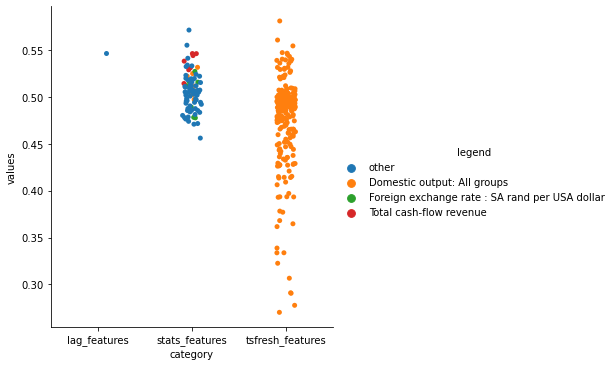

In [66]:
#plt.legend(loc='upper right')
ax=sns.catplot(x="category", y="values", hue = 'legend',data=r2_scores_cat)
#plt.gcf().set_size_inches(10, 10)
plt.savefig('catplot.png')